#**Head Pose Estimation**
- head pose estimation has become a popular area of research. Data scientists have spent over 20 years researching the most effective approaches to it, уеt haven’t settled for one. The technology is needed for facial recognition, eye gaze estimation and emotion recognition. For instance, it can be used for safety monitoring on the road, where we need to understand whether a driver pays attention to the road or not. Finally, It could also be used in computer graphics and VR applications to render a specific scene correctly.

- In this project we will draw the 3 position axis (pitch,yaw,roll) by predicting the 3 angels of each position by training 3 models to predict each angel. 
- We will use [AFLW2000](http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip) dataset with contains 2000 image and 2000 matlab file with contains the 3 labels (angels).
- We will use MediaPipe library in both training and testing phases:
  - In Training: first we dtect the face of each image then using the same library to generate the landmark points of the face after this phase the training data (features) will contain 1853 samples with 936 columns (468 for X and 468 for Y), for labels we will extract the 3 angels from the mat file. 
  - In Testing: we will use the MediaPipe Library to generate the landmarks as we did in the training phase and using the trained models to predict the 3 labels and using them to draw the axis.  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Installing mediapipe

In [2]:
%%capture
!pip install mediapipe
!pip install mat4py
!pip install PyQt5
!pip install nb_helpers

Required Libraries

In [3]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.svm import SVR
import cv2
import mediapipe as mp
import urllib.request

import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import PyQt5
from PIL import Image
# from IPython.display import Video
import nb_helpers
import os
import math
import glob
import random
import scipy as sc
from math import sin, cos
import plotly.express as px
import seaborn as sns
from PIL import Image, ImageFilter
import dlib
from mat4py import loadmat
from sklearn.model_selection import train_test_split



In [4]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose
mp_face_mesh = mp.solutions.face_mesh

### Dowlining Data

In [5]:
# Loading AFLW2000 Data
#%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

###Drawing the axis on the image.

In [6]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Exploring Data


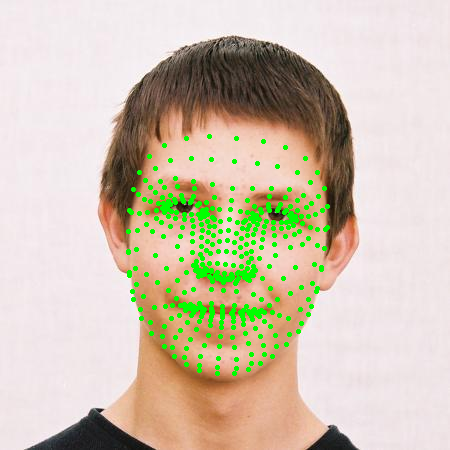

468
468


In [7]:
# choosing random image
random_file = 'image00050'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      x_list = []
      y_list = []
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])   # shape[1] -> img_w
              relative_y = int(y * shape[0])   # shape[0] -> img_h
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
              x_list.append(relative_x)
              y_list.append(relative_y)
      cv2_imshow(image)
      print(len(x_list))
      print(len(y_list))
      face_found = bool(results.multi_face_landmarks)

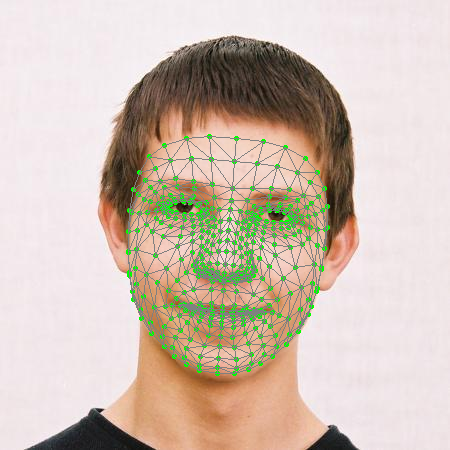

In [8]:
if face_found:
    # Create a copy of the image
    annotated_image = image.copy()
    
    # Draw landmarks on face
    mp_drawing.draw_landmarks(
        image=annotated_image,
        landmark_list=results.multi_face_landmarks[0],
        connections=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
        
    # Save image
    cv2.imwrite('face_tesselation_only.png', annotated_image)

# Open image
img = Image.open('face_tesselation_only.png')
display(img)

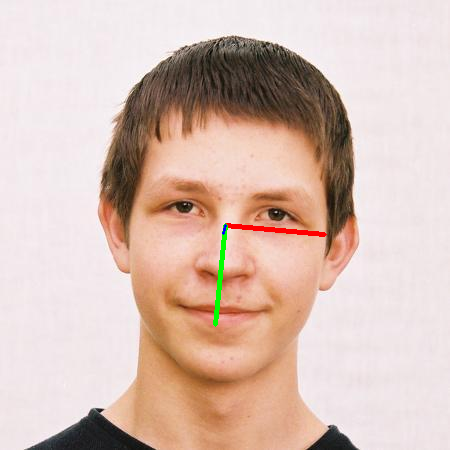

In [9]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

#get landmarks for images

In [10]:
def image_landmarks(image):

    xlist=[]
    ylist=[]
    p1=[]
    p2=[]
      
    faceModule = mp.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as facemesh:
        
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert to RGB
        
        result = facemesh.process(rgb_image)  # Process the image

        if result.multi_face_landmarks != None:   # If there is a face
         
          for face_landmarks in result.multi_face_landmarks:  # For each face
              for landmark in face_landmarks.landmark:
                  # x, y coordinates of the landmarks
                  x = landmark.x
                  y = landmark.y
                  shape = image.shape
                  # actual location Points of the face
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  
                  xlist.append(relative_x)
                  ylist.append(relative_y)
  
                  if landmark == face_landmarks.landmark[1]:  # First point of the face (nose)
                    p1.append(relative_x)  
                    p1.append(relative_y) 
                    
                  if landmark == face_landmarks.landmark[27]: # Second point of the face (top right of the face)
                    p2.append(relative_x)
                    p2.append(relative_y)

    return xlist, ylist, p1, p2

#Preprocessing and normalize

In [11]:
def normalize(landmarks):
  x_1, y_1 = landmarks[2][0], landmarks[2][1]  # nose
  x_2, y_2 = landmarks[3][0], landmarks[3][1]  # top right of the face
  nose = np.array([x_1, y_1])
  trf = np.array([x_2, y_2])
  distance = np.linalg.norm(nose-trf)  # distance between nose and top right of the face
  x_norm_lm = (np.array(landmarks[0]) - x_1) / distance   # normalize x
  y_norm_lm = (np.array(landmarks[1]) - y_1) / distance   # normalize y

  return x_norm_lm, y_norm_lm

#Extracting labels

In [12]:
#Extracting the pose parameters from the mat file.
def pose_parameters(mat_file):
  pose_para = mat_file["Pose_Para"][0][:3] 
  pitch = pose_para[0]
  yaw   = pose_para[1]
  roll  = pose_para[2]
  return [yaw, pitch, roll]

In [13]:
x_columns_names=[] # x-coordinates of the landmarks 
y_columns_names=[]  # y-coordinates of the landmarks
for i in range(468):  # for each landmark
  x_columns_names.append('x_'+str(i))   # create x-coordinate column names
  y_columns_names.append('y_'+str(i))   # create y-coordinate column names
y_predict_columns_names=['yaw', 'pitch', 'roll']   

df = pd.DataFrame(columns = x_columns_names + y_columns_names + y_predict_columns_names) # create dataframe

In [14]:
path='/content/AFLW2000'
Images_Names = [Path(f).stem for f in glob.glob("/content/AFLW2000/*.mat")] # get all the names of the images
for imagename in Images_Names:  # for each image
  img = cv2.imread(path + '/' + imagename + '.jpg')  # read the image

  img_lm = image_landmarks(img)   # get the landmarks of the image

  if img_lm[0]==[] or img_lm[1]==[] or img_lm[2]==[] or img_lm[3]==[]:  # if the landmarks are not extracted
    continue

  x, y = normalize(img_lm)  # normalize the landmarks

  mat_file = sio.loadmat(path + '/' + imagename + '.mat')
  
  df.loc[len(df)] = list(x) + list(y) + pose_parameters(mat_file) #Append data of each sample (image) to the row of dataframe

#displaying data

In [15]:
df

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_461,y_462,y_463,y_464,y_465,y_466,y_467,yaw,pitch,roll
0,0.117596,0.0,0.146995,0.044099,0.000000,0.044099,0.220493,-0.088197,0.264591,0.264591,...,0.044099,0.073498,-0.690878,-0.661479,-0.617380,-0.705577,-0.749676,0.686637,-0.193485,0.006716
1,0.256589,0.0,0.183278,-0.091639,-0.054983,-0.054983,-0.018328,-0.476523,-0.073311,-0.128295,...,0.018328,0.036656,-0.953046,-0.879735,-0.824751,-1.172980,-1.282947,0.451164,-0.224407,-0.341339
2,0.059047,0.0,0.059047,-0.073809,-0.014762,0.000000,0.059047,-0.664284,0.073809,0.059047,...,0.059047,0.103333,-0.708569,-0.664284,-0.649522,-0.797140,-0.856188,0.222834,0.058342,-0.018372
3,-0.032578,0.0,-0.021719,-0.076015,0.010859,0.010859,0.000000,-0.716714,-0.010859,0.000000,...,0.043437,0.054297,-0.651558,-0.629840,-0.608121,-0.684136,-0.716714,-0.078198,-0.095902,0.001859
4,-0.253824,0.0,-0.217563,-0.060434,0.048347,0.036261,-0.048347,-0.676864,-0.024174,0.036261,...,0.036261,0.036261,-0.531822,-0.507648,-0.483474,-0.495561,-0.519735,-1.130585,-0.190476,0.738074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.176200,0.0,0.234933,0.156622,-0.019578,0.078311,0.391555,0.391555,0.469866,0.469866,...,0.078311,0.137044,-0.685222,-0.646066,-0.626488,-0.685222,-0.743955,1.246780,0.314728,0.228997
1849,0.047935,0.0,-0.009587,-0.210915,-0.038348,-0.086284,-0.230089,-0.939532,-0.316373,-0.364308,...,0.009587,0.028761,-0.623159,-0.584811,-0.565637,-0.805313,-0.853249,-0.153506,0.054691,-0.324494
1850,-0.113541,0.0,-0.041288,0.051610,0.030966,0.092897,0.216760,-0.381910,0.309657,0.371588,...,0.051610,0.061931,-0.495451,-0.495451,-0.485129,-0.381910,-0.392232,0.087130,-0.138380,0.405625
1851,0.012740,0.0,0.000000,-0.089181,0.000000,0.000000,-0.012740,-0.675228,-0.025480,-0.025480,...,0.025480,0.038220,-0.662488,-0.637007,-0.611527,-0.726188,-0.764409,0.011347,-0.131794,-0.020842


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1853 entries, 0 to 1852
Columns: 939 entries, x_0 to roll
dtypes: float64(939)
memory usage: 13.3 MB


In [17]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
x_0,1853.0,0.023488,0.151449,-0.383912,-0.085324,0.010847,0.119720,0.822981
x_1,1853.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
x_2,1853.0,0.020445,0.129638,-0.261942,-0.061633,0.008998,0.091024,0.649722
x_3,1853.0,-0.066266,0.107261,-0.332718,-0.131922,-0.082254,-0.017371,0.363894
x_4,1853.0,-0.003079,0.029382,-0.163129,-0.018710,0.000000,0.013040,0.121984
...,...,...,...,...,...,...,...,...
y_466,1853.0,-0.703893,0.269869,-2.685518,-0.827476,-0.695421,-0.569290,0.801608
y_467,1853.0,-0.748487,0.289494,-2.945407,-0.876860,-0.733296,-0.602237,0.853887
yaw,1853.0,0.013611,0.580266,-6.130066,-0.256714,0.019403,0.305791,3.277500
pitch,1853.0,-0.095366,0.549292,-12.457202,-0.246453,-0.123371,0.028133,15.598820


In [18]:
df.isna().sum().sort_values(ascending=True)

x_0      0
y_150    0
y_151    0
y_152    0
y_153    0
        ..
x_318    0
x_319    0
x_320    0
x_308    0
roll     0
Length: 939, dtype: int64

#Splitting the data

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[x_columns_names + y_columns_names], df[y_predict_columns_names], test_size=0.2, random_state=7)

In [20]:
X_train

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_458,y_459,y_460,y_461,y_462,y_463,y_464,y_465,y_466,y_467
1287,0.031330,0.0,0.020887,-0.052217,-0.010443,0.000000,0.041773,-0.522167,0.052217,0.052217,...,0.000000,-0.020887,0.000000,0.020887,0.020887,-0.657930,-0.626600,-0.584826,-0.731033,-0.772806
1435,-0.131157,0.0,-0.131157,-0.166927,0.000000,-0.047693,-0.202697,-0.906176,-0.262314,-0.262314,...,0.023847,-0.011923,0.035770,0.023847,0.047693,-0.512705,-0.488858,-0.465011,-0.572321,-0.608092
1301,-0.170174,0.0,-0.116995,-0.021272,0.031908,0.042544,0.042544,-0.563702,0.095723,0.138267,...,-0.010636,-0.031908,-0.042544,0.000000,0.000000,-0.638153,-0.606246,-0.574338,-0.680697,-0.701969
1138,0.026707,0.0,0.013354,-0.093475,-0.013354,-0.013354,-0.013354,-0.707737,-0.013354,-0.013354,...,0.026707,-0.013354,0.040061,0.040061,0.053414,-0.721090,-0.681030,-0.654323,-0.814565,-0.827919
651,-0.030967,0.0,-0.030967,-0.134192,0.000000,-0.030967,-0.103225,-0.836119,-0.134192,-0.144514,...,-0.010322,-0.041290,-0.061935,0.010322,0.010322,-0.650314,-0.609025,-0.588380,-0.753539,-0.794829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,0.160024,0.0,0.060009,-0.240036,-0.050008,-0.120018,-0.280042,-0.900135,-0.420063,-0.490074,...,-0.030005,-0.090014,-0.130020,-0.010002,0.000000,-0.710107,-0.660099,-0.630095,-1.010152,-1.060159
502,-0.023794,0.0,-0.023794,-0.083280,0.000000,-0.011897,-0.011897,-0.701933,-0.023794,-0.023794,...,0.023794,-0.011897,-0.011897,0.035692,0.047589,-0.618653,-0.594859,-0.582962,-0.678139,-0.725728
537,0.138875,0.0,0.180538,0.124988,0.000000,0.083325,0.361076,0.083325,0.458289,0.472177,...,0.097213,0.069438,0.180538,0.097213,0.124988,-0.611052,-0.583277,-0.569390,-0.527727,-0.569390
1220,0.107086,0.0,0.091788,-0.076490,-0.015298,0.000000,0.030596,-0.627216,0.030596,0.015298,...,0.030596,-0.015298,0.076490,0.045894,0.076490,-0.764898,-0.719004,-0.688408,-0.841388,-0.917878


In [21]:
y_train

,yaw,pitch,roll
1287,0.100288,-0.289337,0.003714
1435,-0.805052,0.091514,-0.112528
1301,-0.414339,-0.458591,0.363715
1138,0.053030,-0.119412,-0.019507
651,-0.166567,-0.179746,-0.121193
...,...,...,...
1603,-0.032469,-0.213670,-0.527061
502,0.002695,-0.109741,-0.006967
537,0.639374,-0.026205,0.175747
1220,0.267560,0.041948,-0.074263


#creating different models to choose the best of them

In [22]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

multioutputregressor = MultiOutputRegressor(SVR()).fit(X_train, y_train)
predictions = multioutputregressor.predict(X_test)

# model evaluation for testing set
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)


In [23]:
print(f"mean_absolute_error: {mae}")
print(f"mean_squared_error: {mse}")
print(f"r2_score: {r2}")

mean_absolute_error: 0.07184180795289845
mean_squared_error: 0.018668839077215633
r2_score: 0.8337100615496463


In [24]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV



#find best parameters for SVR
param_grid = {'estimator__kernel': ['rbf'],
                'estimator__C': [10,100],
                    'estimator__epsilon': [0.1, 0.01]}



MultiOutputRegressor_SVR_model = MultiOutputRegressor(SVR())
grid_search = GridSearchCV(MultiOutputRegressor_SVR_model, param_grid, cv=5, n_jobs=-1, verbose=1)
gs_f=grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [25]:
# printing the best parameters and the best score
print(f"Best parameters found on training set: {gs_f.best_params_}")
print(f"Best score found on training set: {gs_f.best_score_}")
print(f"Best score found on testing set: {gs_f.score(X_test, y_test)}")


# predicting the test set
predictions = gs_f.predict(X_test)


# model evaluation for testing set
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)


print(f"mean_absolute_error: {mae}")
print(f"mean_squared_error: {mse}")
print(f"r2_score: {r2}")

Best parameters found on training set: {'estimator__C': 10, 'estimator__epsilon': 0.01, 'estimator__kernel': 'rbf'}
Best score found on training set: 0.6014761732083539
Best score found on testing set: 0.8625621694429927
mean_absolute_error: 0.06606326359364563
mean_squared_error: 0.015418238785927416
r2_score: 0.8625621694429927


In [33]:
from sklearn.ensemble import RandomForestRegressor


#finding best parameters for RandomForestRegressor
param_grid = {'estimator__n_estimators': [20,100],
              'estimator__max_depth': [10,20]}
              


MultiOutputRegressor_RandomForestRegressor_model = MultiOutputRegressor(RandomForestRegressor())
grid_search = GridSearchCV(MultiOutputRegressor_RandomForestRegressor_model, param_grid, cv=5, n_jobs=-1, verbose=1)
gs_efr_F=grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [34]:
# printing the best parameters and the best score
print(f"Best parameters found on training set: {gs_efr_F.best_params_}")
print(f"Best score found on training set: {gs_efr_F.best_score_}")
print(f"Best score found on testing set: {gs_efr_F.score(X_test, y_test)}")
    


# predicting the test set
predictions = gs_efr_F.predict(X_test)

        
# model evaluation for testing set
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)

print(f"mean_absolute_error: {mae}")
print(f"mean_squared_error: {mse}")
print(f"r2_score: {r2}")


Best parameters found on training set: {'estimator__max_depth': 10, 'estimator__n_estimators': 20}
Best score found on training set: -0.2599077360197152
Best score found on testing set: -0.43100293371496806
mean_absolute_error: 0.10774633287230528
mean_squared_error: 0.14206033973822732
r2_score: -0.43100293371496806


In [27]:
from xgboost.sklearn import XGBRegressor


#finding best parameters for XGBRegressor
param_grid = {'estimator__n_estimators': [100,200,300],
                'estimator__max_depth': [2,4]}


MultiOutputRegressor_XGBRegressor_model = MultiOutputRegressor(XGBRegressor())
grid_search = GridSearchCV(MultiOutputRegressor_XGBRegressor_model, param_grid, cv=5, n_jobs=-1, verbose=1)
gs_xgr_F=grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[11:06:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:07:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:07:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [28]:
# printing the best parameters and the best score
print(f"Best parameters found on training set: {gs_xgr_F.best_params_}")
print(f"Best score found on training set: {gs_xgr_F.best_score_}")
print(f"Best score found on testing set: {gs_xgr_F.score(X_test, y_test)}")

# predicting the test set
predictions = gs_xgr_F.predict(X_test)


# model evaluation for testing set
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

Best parameters found on training set: {'estimator__max_depth': 2, 'estimator__n_estimators': 300}
Best score found on training set: -1.5706654446474766
Best score found on testing set: -1.9349760441931698
MAE: 0.11100106195993363
MSE: 0.2381137954267872
R2: -1.9349760441931698


In [30]:
from sklearn.ensemble import AdaBoostRegressor


#find best parameters for AdaBoostRegressor
param_grid = {'estimator__n_estimators': [100],
                'estimator__learning_rate': [0.1,0.2]}


MultiOutputRegressor_AdaBoostRegressor_model = MultiOutputRegressor(AdaBoostRegressor())
grid_search = GridSearchCV(MultiOutputRegressor_AdaBoostRegressor_model, param_grid, cv=5, n_jobs=-1, verbose=1)
gs_abr_F=grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [31]:
# printing the best parameters and the best score
print(f"Best parameters found on training set: {gs_abr_F.best_params_}")
print(f"Best score found on training set: {gs_abr_F.best_score_}")
print(f"Best score found on testing set: {gs_abr_F.score(X_test, y_test)}")


# predicting the test set
predictions = gs_abr_F.predict(X_test)


# model evaluation for testing set
from sklearn import metrics
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)


print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2: {r2}")

Best parameters found on training set: {'estimator__learning_rate': 0.1, 'estimator__n_estimators': 100}
Best score found on training set: -1.1975047155076712
Best score found on testing set: 0.5131240614119851
MAE: 0.15558808197466167
MSE: 0.05561711067291325
R2: 0.5131240614119851


In [32]:
import cv2
cap = cv2.VideoCapture('/content/drive/MyDrive/ML1_Final_Project/video_t2.mp4')
# video_name = 'Out_Video3.mp4'
frame_width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# video = cv2.VideoWriter(video_name, 0, 10, (1280,720))
video_writer=cv2.VideoWriter('video_t2_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, (frame_width,frame_height))

df2 = pd.DataFrame(columns = x_columns_names+y_columns_names)

while (cap.isOpened()):
  success, frame = cap.read()
  if success is not True :
    break
  frame_height, frame_width, frame_channel = frame.shape
  
  img_lm=image_landmarks(frame)

  if img_lm[0]==[] or img_lm[1]==[] or img_lm[2]==[] or img_lm[3]==[]:
    continue

  x, y = normalize(img_lm)

  df2.loc[len(df2)] = list(x) + list(y) 

  res = gs_f.predict(df2.tail(1))

  output = draw_axis(frame, res[0][1], res[0][0], res[0][2], img_lm[2][0], img_lm[2][1])

  video_writer.write(output)

cv2.destroyAllWindows()
video_writer.release()